# Exploring Dandiset 001366: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

> **IMPORTANT NOTICE**: This notebook was AI-generated and has not been fully verified. Please exercise caution when interpreting the code or results. Always validate findings independently when using for research purposes.

## Overview

This notebook explores [Dandiset 001366 (version 0.250324.1603)](https://dandiarchive.org/dandiset/001366/0.250324.1603), which contains imaging data of pial blood vessels from mice. The dataset's focus is on comparing different approaches for quantifying vessel diameter and pulsatility. 

The dataset includes movies of blood vessels captured through cranial windows, allowing for the observation of vessel dynamics over time. These recordings can be used to evaluate various vessel diameter measurement techniques and analyze pulsatility patterns that reflect cardiovascular dynamics.

In this notebook, we will:

1. Load and explore the structure of the NWB files in the Dandiset
2. Visualize sample frames of vessel imaging data
3. Extract vessel cross-sections and analyze intensity profiles
4. Implement and compare different methods for vessel diameter measurement
5. Analyze vessel pulsatility through diameter time series
6. Perform frequency domain analysis of vessel pulsations

## Required Packages

This notebook uses the following packages:

- `pynwb`: For reading and working with NWB files
- `h5py`: For low-level access to HDF5 files (which NWB files use)
- `remfile`: For streaming remote files
- `matplotlib`: For creating visualizations
- `numpy`: For numerical operations
- `scipy`: For signal processing and scientific computing
- `seaborn`: For enhanced visualization styling

In [1]:
# Import required packages
import pynwb
import h5py
import remfile
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

# Set up the plot styling
sns.set_theme()

## Loading the Dandiset

We'll use the DANDI API to access the dataset. First, we'll connect to the DANDI archive and retrieve the Dandiset metadata.

In [2]:
from itertools import islice
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001366", "0.250324.1603")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata['description']}")
print(f"Keywords: {', '.join(metadata['keywords'])}")
print(f"License: {', '.join(metadata['license'])}")

# For contributors, we need to handle the fact they might be complex objects rather than strings
print("Contributors:")
for contributor in metadata.get('contributor', []):
    if isinstance(contributor, str):
        print(f"- {contributor}")
    elif isinstance(contributor, dict):
        # Extract name if available, otherwise use the whole contributor dictionary
        print(f"- {contributor.get('name', str(contributor))}")
    else:
        print(f"- {contributor}")

Dandiset name: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification
Dandiset URL: https://dandiarchive.org/dandiset/001366/0.250324.1603
Description: movies of a pial vessel of mice used in the experiments.
Keywords: full width at half maximum, vessel pulsation, image analysis, vessel diameter, radon transform
License: spdx:CC-BY-4.0
Contributors:
- Zhao, Yue
- Ranjan, Aditya
- Wong, Devin T.
- Huang, Qinwen
- Ghanizada, Hashmat
- Nedergaard, Maiken 
- Kelley, Douglas H. 
- Boster, Kimberly A. S.
- National Institute of Health
- National Institute of Health
- United States Army


## Exploring the Dandiset Assets

In [3]:
# List the assets in the Dandiset
assets = dandiset.get_assets()
print(f"\nAssets in the Dandiset:")
asset_list = list(islice(assets, 10))  # Get only the first 10 assets
for asset in asset_list:  # Show only the first 10 assets
    print(f"- {asset.path} (ID: {asset.identifier})")


Assets in the Dandiset:
- sub-F15/sub-F15_ses-F15BC-19102023_image.nwb (ID: 71fa07fc-4309-4013-8edd-13213a86a67d)
- sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb (ID: 2f12bce3-f841-46ca-b928-044269122a59)


The Dandiset contains two NWB files:

1. `sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb`: A larger dataset from subject M4
2. `sub-F15/sub-F15_ses-F15BC-19102023_image.nwb`: A smaller dataset from subject F15

Let's explore each of these files, focusing on the vessel imaging data they contain.

## Exploring the NWB File Structure

We'll start by examining the F15 dataset, which is smaller and easier to work with. This will give us a better understanding of the NWB file structure and the vessel imaging data.

In [4]:
# Load the F15 NWB file
url_f15 = "https://api.dandiarchive.org/api/assets/71fa07fc-4309-4013-8edd-13213a86a67d/download/"
print(f"Loading NWB file from {url_f15}")

remote_file_f15 = remfile.File(url_f15)
h5_file_f15 = h5py.File(remote_file_f15)
io_f15 = pynwb.NWBHDF5IO(file=h5_file_f15)
nwb_f15 = io_f15.read()

Loading NWB file from https://api.dandiarchive.org/api/assets/71fa07fc-4309-4013-8edd-13213a86a67d/download/


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Basic Information about the F15 Dataset

In [5]:
# Print basic information about the F15 dataset
print("Subject Information:")
print(f"Subject ID: {nwb_f15.subject.subject_id}")
print(f"Age: {nwb_f15.subject.age}")
print(f"Sex: {nwb_f15.subject.sex}")
print(f"Strain: {nwb_f15.subject.strain}")
print(f"Species: {nwb_f15.subject.species}")
print(f"Description: {nwb_f15.subject.description}")

print("\nSession Information:")
print(f"Session ID: {nwb_f15.session_id}")
print(f"Session Description: {nwb_f15.session_description[:200]}...")
print(f"Experiment Description: {nwb_f15.experiment_description}")
print(f"Institution: {nwb_f15.institution}")
print(f"Session Start Time: {nwb_f15.session_start_time}")

# Print information about the Movies dataset
movies_f15 = nwb_f15.acquisition["Movies"]
print("\nMovies Dataset Information:")
print(f"Shape: {movies_f15.data.shape}")
print(f"Data Type: {movies_f15.data.dtype}")
print(f"Frame Rate: {movies_f15.rate} frames/second")
print(f"Description: {movies_f15.description}")
print(f"Unit: {movies_f15.unit}")
print(f"Total Duration: {movies_f15.data.shape[0] / movies_f15.rate:.2f} seconds")

Subject Information:
Subject ID: F15
Age: P9W/P16W
Sex: F
Strain: C57BL/6J
Species: Mus musculus
Description: wild-type mouse

Session Information:
Session ID: F15BC-19102023
Session Description: a wild-type mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with a head plate for fixation....
Experiment Description: Vessel diameter and pulsatility measurement.
Institution: University of Copenhagen
Session Start Time: 2023-10-19 02:00:00-04:00

Movies Dataset Information:
Shape: (9553, 214, 132)
Data Type: uint16
Frame Rate: 54.47 frames/second
Description: 16-bit grayscale movie of a pial vessel
Unit: n.a.
Total Duration: 175.38 seconds


You can access this NWB file in Neurosift with the following link:

[View F15 NWB file in Neurosift](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/71fa07fc-4309-4013-8edd-13213a86a67d/download/&dandisetId=001366&dandisetVersion=0.250324.1603)

Now let's look at the larger M4 dataset:

In [6]:
# Load the M4 NWB file
url_m4 = "https://api.dandiarchive.org/api/assets/2f12bce3-f841-46ca-b928-044269122a59/download/"
print(f"Loading NWB file from {url_m4}")

remote_file_m4 = remfile.File(url_m4)
h5_file_m4 = h5py.File(remote_file_m4)
io_m4 = pynwb.NWBHDF5IO(file=h5_file_m4)
nwb_m4 = io_m4.read()

Loading NWB file from https://api.dandiarchive.org/api/assets/2f12bce3-f841-46ca-b928-044269122a59/download/


In [7]:
# Print basic information about the M4 dataset
print("Subject Information:")
print(f"Subject ID: {nwb_m4.subject.subject_id}")
print(f"Age: {nwb_m4.subject.age}")
print(f"Sex: {nwb_m4.subject.sex}")
print(f"Strain: {nwb_m4.subject.strain}")
print(f"Species: {nwb_m4.subject.species}")
print(f"Description: {nwb_m4.subject.description[:200]}...")

print("\nSession Information:")
print(f"Session ID: {nwb_m4.session_id}")
print(f"Session Description: {nwb_m4.session_description[:200]}...")
print(f"Experiment Description: {nwb_m4.experiment_description}")
print(f"Institution: {nwb_m4.institution}")
print(f"Session Start Time: {nwb_m4.session_start_time}")

# Print information about the Movies dataset
movies_m4 = nwb_m4.acquisition["Movies"]
print("\nMovies Dataset Information:")
print(f"Shape: {movies_m4.data.shape}")
print(f"Data Type: {movies_m4.data.dtype}")
print(f"Frame Rate: {movies_m4.rate} frames/second")
print(f"Description: {movies_m4.description}")
print(f"Unit: {movies_m4.unit}")
print(f"Total Duration: {movies_m4.data.shape[0] / movies_m4.rate:.2f} seconds")

Subject Information:
Subject ID: 031224_M4
Age: P2M
Sex: M
Strain: C57BL/6
Species: Mus musculus
Description: Before the imaging, the mouse was anesthetized with ketamine and xylazine cocktail (80 mg/kg, 10 mg/kg), then retro-orbital injected with fluorescent tracer (0.1 ml, 1%, albumin from Bovine serum 647,...

Session Information:
Session ID: 03122024-m4-baseline
Session Description: the mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with a head plate for fixation....
Experiment Description: Vessel diameter and pulsatility measurement.
Institution: University of Rochester
Session Start Time: 2024-03-12 01:00:00-04:00

Movies Dataset Information:
Shape: (6000, 512, 512)
Data Type: uint16
Frame Rate: 30.0 frames/second
Description: 16-bit grayscale movie of a pial vessel
Unit: n.a.
Total Duration: 200.00 seconds


You can access this NWB file in Neurosift with the following link:

[View M4 NWB file in Neurosift](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/2f12bce3-f841-46ca-b928-044269122a59/download/&dandisetId=001366&dandisetVersion=0.250324.1603)

## Visualizing the Vessel Images

Let's visualize a sample frame from each dataset to understand the vessel structure and imaging quality.

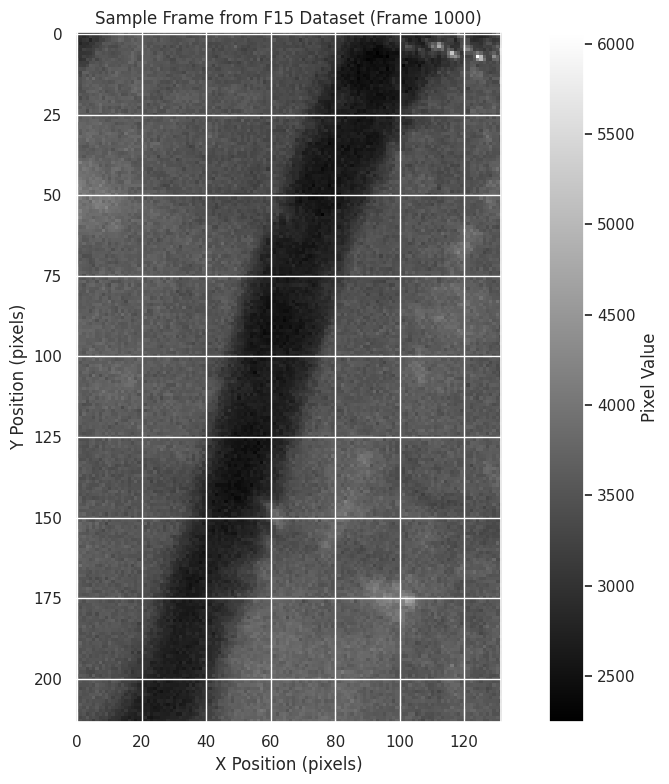

In [8]:
# Load and display a sample frame from the F15 dataset
frame_idx_f15 = 1000
frame_f15 = movies_f15.data[frame_idx_f15, :, :]

plt.figure(figsize=(10, 8))
plt.imshow(frame_f15, cmap='gray')
plt.colorbar(label='Pixel Value')
plt.title(f"Sample Frame from F15 Dataset (Frame {frame_idx_f15})")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.tight_layout()
plt.show()

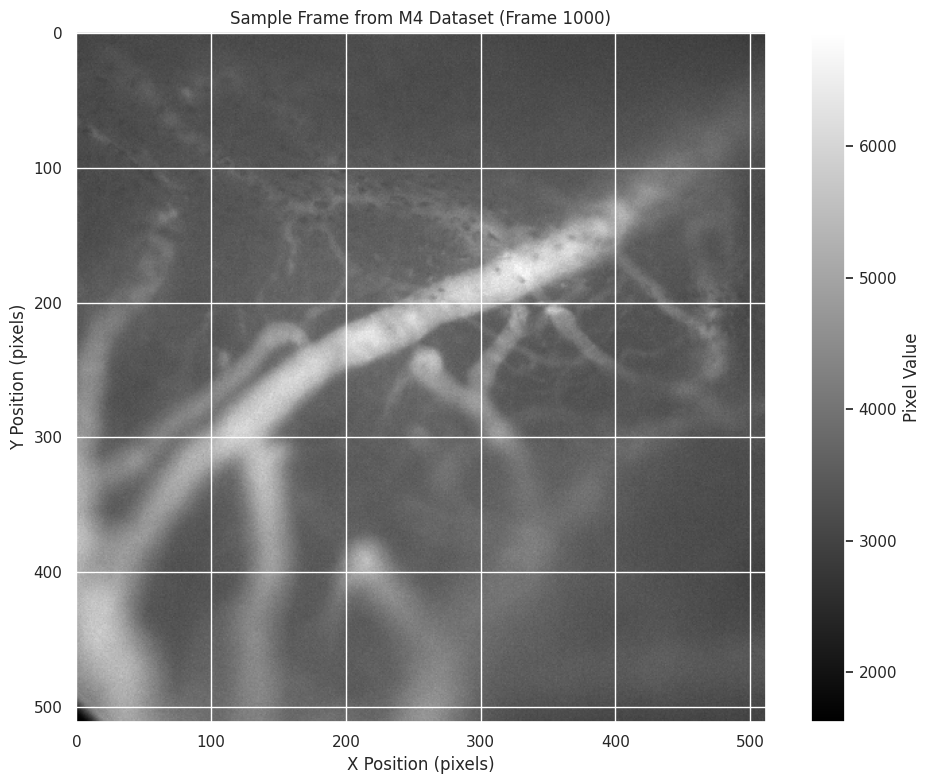

In [9]:
# Load and display a sample frame from the M4 dataset
frame_idx_m4 = 1000
frame_m4 = movies_m4.data[frame_idx_m4, :, :]

plt.figure(figsize=(10, 8))
plt.imshow(frame_m4, cmap='gray')
plt.colorbar(label='Pixel Value')
plt.title(f"Sample Frame from M4 Dataset (Frame {frame_idx_m4})")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.tight_layout()
plt.show()

## Analyzing Vessel Diameter

One of the key aspects of this dataset is the comparison of different methods for vessel diameter measurement. The dataset papers mention techniques like:

1. Full Width at Half Maximum (FWHM)
2. Radon Transform-based methods
3. Threshold-based segmentation

Let's implement and compare two of these approaches: FWHM and threshold-based methods.

### Step 1: Define a cross-section for vessel diameter measurement

First, we need to identify the vessel orientation and define a perpendicular cross-section for measurement.

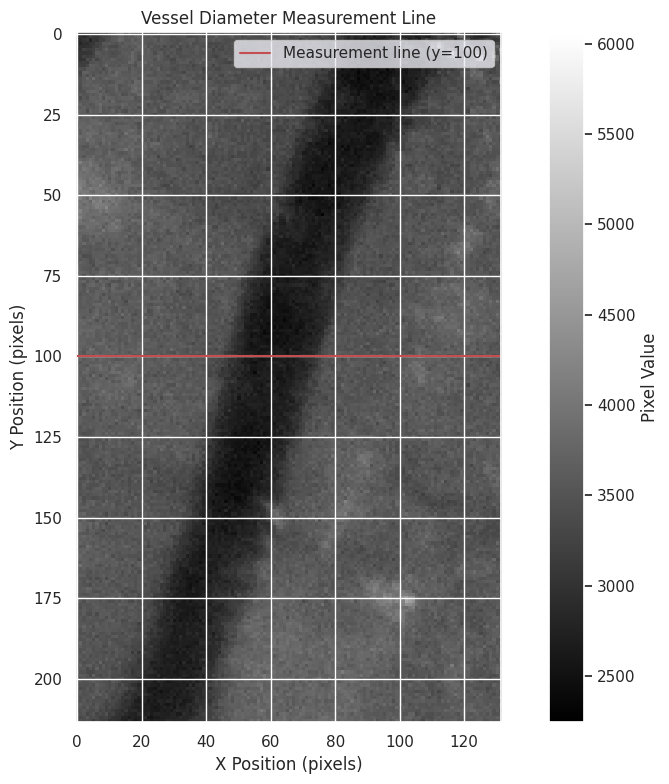

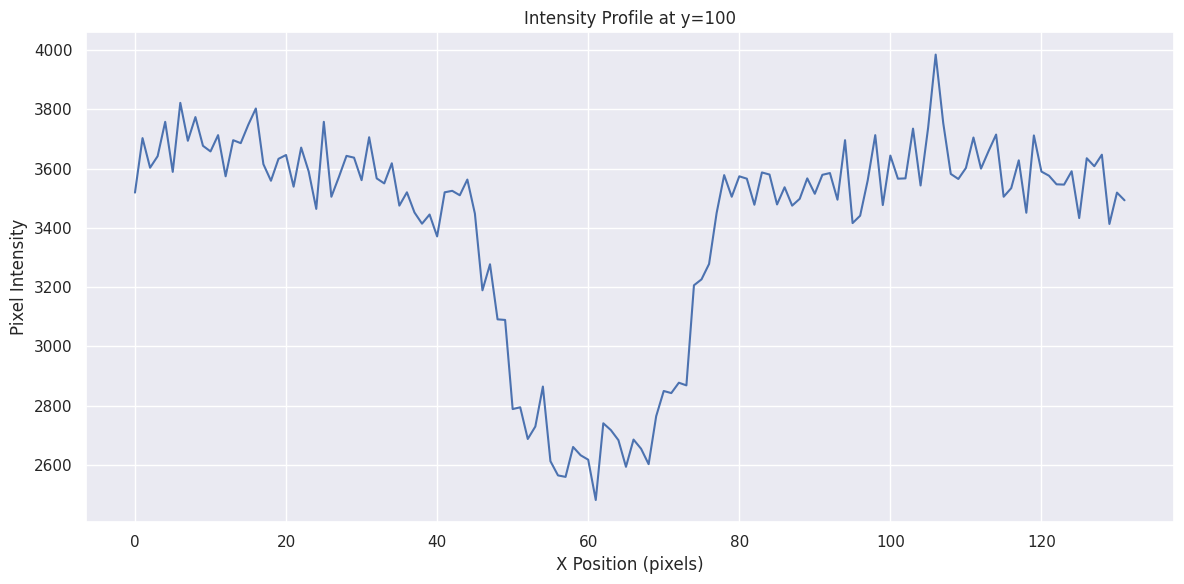

In [10]:
# We'll work with the F15 dataset which has clearer vessel structure
# Define the y-position for our cross-section
y_position = 100

# Visualize the cross-section line on the frame
plt.figure(figsize=(10, 8))
plt.imshow(frame_f15, cmap='gray')
plt.axhline(y=y_position, color='r', linestyle='-', label=f'Measurement line (y={y_position})')
plt.title("Vessel Diameter Measurement Line")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.colorbar(label='Pixel Value')
plt.legend()
plt.tight_layout()
plt.show()

# Extract the intensity profile along this cross-section
intensity_profile = frame_f15[y_position, :]

# Plot the intensity profile
plt.figure(figsize=(12, 6))
plt.plot(intensity_profile)
plt.title(f"Intensity Profile at y={y_position}")
plt.xlabel("X Position (pixels)")
plt.ylabel("Pixel Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 2: Implement vessel diameter measurement methods

Now let's implement the FWHM and threshold-based methods for vessel diameter measurement.

In [11]:
# Function to measure vessel diameter using FWHM
def measure_fwhm(profile):
    """
    Measure vessel diameter using the Full Width at Half Maximum (FWHM) method.
    In the F15 dataset, vessels appear as dark structures (lower intensity).
    """
    # Invert the profile (so vessel is a peak rather than a valley)
    inverted_profile = np.max(profile) - profile
    
    # Smooth the profile to reduce noise
    smoothed_profile = gaussian_filter1d(inverted_profile, sigma=2)
    
    # Find the baseline (minimum) and peak (maximum) values
    baseline = np.min(smoothed_profile)
    peak = np.max(smoothed_profile)
    
    # Calculate the half-maximum value
    half_max = baseline + (peak - baseline) / 2
    
    # Find points where the profile crosses the half-maximum line
    above_half_max = smoothed_profile > half_max
    
    # Find edges
    edges = np.where(np.diff(above_half_max.astype(int)))[0]
    if len(edges) >= 2:
        # Calculate FWHM
        fwhm = edges[-1] - edges[0]
        return fwhm, half_max, smoothed_profile
    else:
        return np.nan, half_max, smoothed_profile

# Function to measure vessel diameter using a threshold
def measure_with_threshold(profile, threshold_percentile=75):
    """
    Measure vessel diameter using a threshold-based method.
    """
    # Invert the profile (so vessel is a peak rather than a valley)
    inverted_profile = np.max(profile) - profile
    
    # Normalize the inverted profile
    normalized_profile = (inverted_profile - np.min(inverted_profile)) / (np.max(inverted_profile) - np.min(inverted_profile))
    
    # Calculate threshold
    threshold = np.percentile(normalized_profile, threshold_percentile)
    
    # Find regions above threshold
    above_threshold = normalized_profile > threshold
    
    # Find vessel edges
    edges = np.where(np.diff(above_threshold.astype(int)))[0]
    
    if len(edges) >= 2:
        # Use first and last edges
        diameter = edges[-1] - edges[0]
        return diameter, threshold, normalized_profile
    else:
        return np.nan, threshold, normalized_profile

# Apply both methods to our intensity profile
fwhm_diameter, half_max, smoothed_profile = measure_fwhm(intensity_profile)
threshold_diameter, threshold, normalized_profile = measure_with_threshold(intensity_profile)

print(f"Vessel diameter using FWHM: {fwhm_diameter:.2f} pixels")
print(f"Vessel diameter using threshold method: {threshold_diameter:.2f} pixels")
print(f"Difference: {abs(fwhm_diameter - threshold_diameter):.2f} pixels")
print(f"Relative Difference: {abs(fwhm_diameter - threshold_diameter)/fwhm_diameter*100:.2f}%")

Vessel diameter using FWHM: 27.00 pixels
Vessel diameter using threshold method: 90.00 pixels
Difference: 63.00 pixels
Relative Difference: 233.33%


### Step 3: Visualize the measurement methods

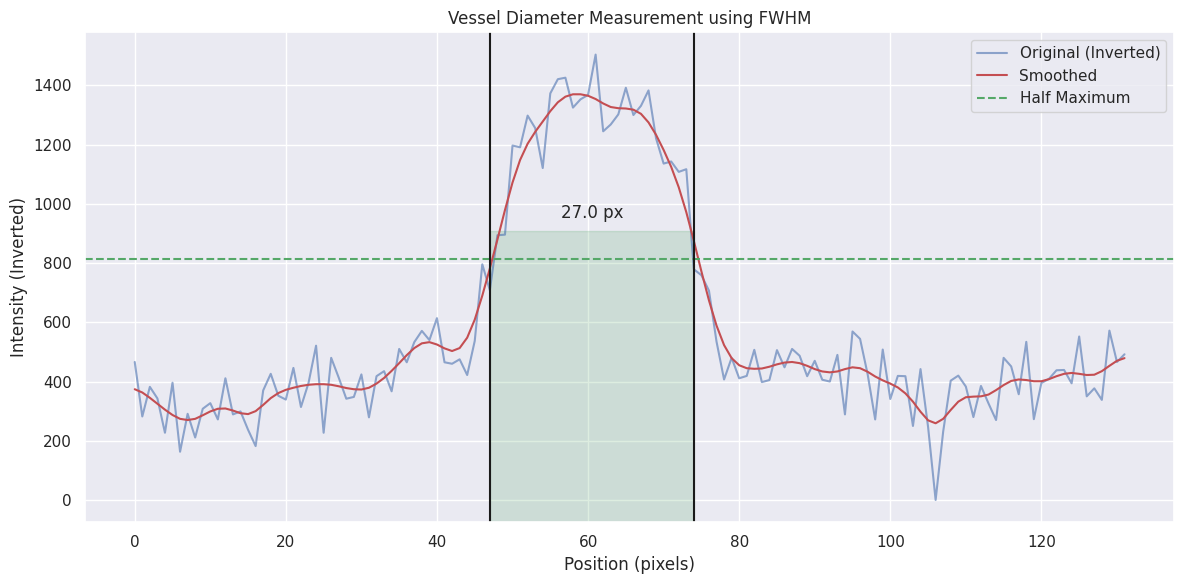

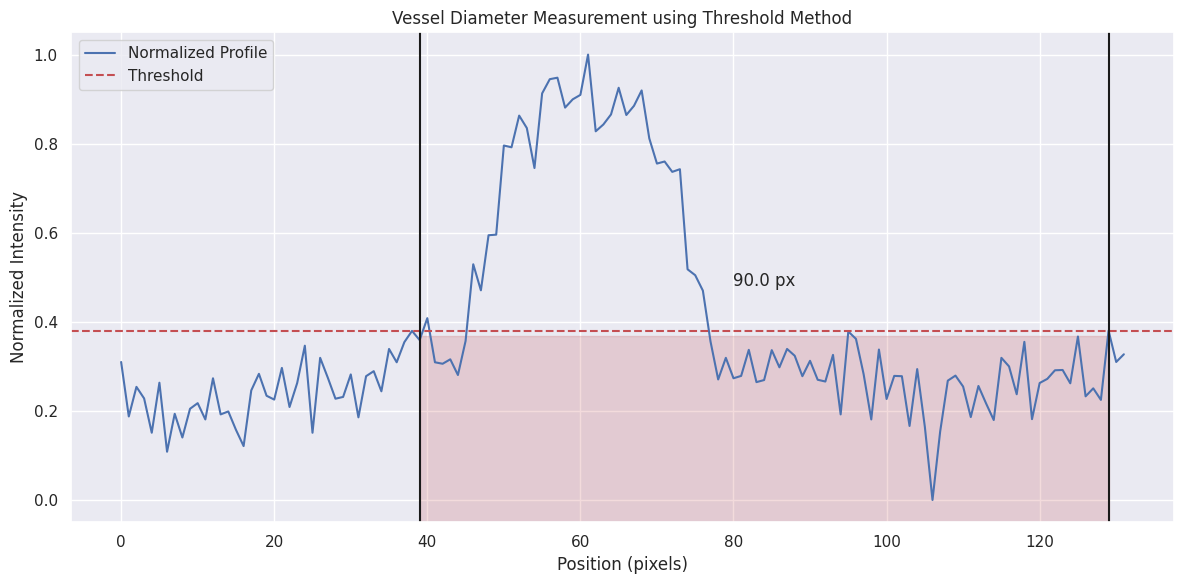

In [12]:
# Visualize the FWHM measurement
plt.figure(figsize=(12, 6))
# Invert the profile for visualization
inverted_profile = np.max(intensity_profile) - intensity_profile
plt.plot(inverted_profile, 'b-', alpha=0.6, label="Original (Inverted)")
plt.plot(smoothed_profile, 'r-', label="Smoothed")
plt.axhline(y=half_max, color='g', linestyle='--', label=f"Half Maximum")

if not np.isnan(fwhm_diameter):
    # Find the edges for FWHM visualization
    above_half_max = smoothed_profile > half_max
    edges = np.where(np.diff(above_half_max.astype(int)))[0]
    if len(edges) >= 2:
        left_edge = edges[0]
        right_edge = edges[-1]
        plt.axvline(x=left_edge, color='k', linestyle='-')
        plt.axvline(x=right_edge, color='k', linestyle='-')
        plt.axvspan(xmin=left_edge, xmax=right_edge, 
                    ymin=0, ymax=half_max / np.max(smoothed_profile),
                    alpha=0.2, color='g')
        plt.text((left_edge + right_edge) / 2, half_max + 0.1 * np.max(smoothed_profile),
                f"{fwhm_diameter:.1f} px", ha='center')

plt.title("Vessel Diameter Measurement using FWHM")
plt.xlabel("Position (pixels)")
plt.ylabel("Intensity (Inverted)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Visualize the threshold-based measurement
plt.figure(figsize=(12, 6))
plt.plot(normalized_profile, 'b-', label="Normalized Profile")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold")

if not np.isnan(threshold_diameter):
    # Find the edges for threshold visualization
    above_threshold = normalized_profile > threshold
    edges = np.where(np.diff(above_threshold.astype(int)))[0]
    if len(edges) >= 2:
        left_edge = edges[0]
        right_edge = edges[-1]
        plt.axvline(x=left_edge, color='k', linestyle='-')
        plt.axvline(x=right_edge, color='k', linestyle='-')
        plt.axvspan(xmin=left_edge, xmax=right_edge, 
                    ymin=0, ymax=threshold,
                    alpha=0.2, color='r')
        plt.text((left_edge + right_edge) / 2, threshold + 0.1,
                f"{threshold_diameter:.1f} px", ha='center')

plt.title("Vessel Diameter Measurement using Threshold Method")
plt.xlabel("Position (pixels)")
plt.ylabel("Normalized Intensity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Analyzing Vessel Pulsatility

Vessel pulsatility is another key aspect of this dataset. We can analyze pulsatility by measuring vessel diameter over time and performing frequency analysis.

### Step 1: Extract vessel diameter time series

In [13]:
# Define the parameters for analysis
# We'll analyze only a subset of frames to keep processing manageable
n_frames = 600  # 600 frames is about 11 seconds at ~54 fps
start_frame = 3000  # Skip the first portion of the recording

# Create arrays to store the results
frames = []
timestamps = []
vessel_diameters_fwhm = []
vessel_diameters_threshold = []

print(f"Loading and analyzing {n_frames} frames starting from frame {start_frame}...")
for i in range(start_frame, start_frame + n_frames):
    # Load the frame
    frame = movies_f15.data[i, :, :]
    frames.append(frame)
    timestamps.append(i / movies_f15.rate)  # Convert frame index to time in seconds
    
    # Extract the intensity profile along our measurement line
    intensity_profile = frame[y_position, :]
    
    # Measure vessel diameter using both methods
    fwhm_diameter, _, _ = measure_fwhm(intensity_profile)
    threshold_diameter, _, _ = measure_with_threshold(intensity_profile)
    
    # Store the results
    vessel_diameters_fwhm.append(fwhm_diameter)
    vessel_diameters_threshold.append(threshold_diameter)

# Convert to numpy arrays
vessel_diameters_fwhm = np.array(vessel_diameters_fwhm)
vessel_diameters_threshold = np.array(vessel_diameters_threshold)

Loading and analyzing 600 frames starting from frame 3000...


### Step 2: Visualize vessel diameter changes over time

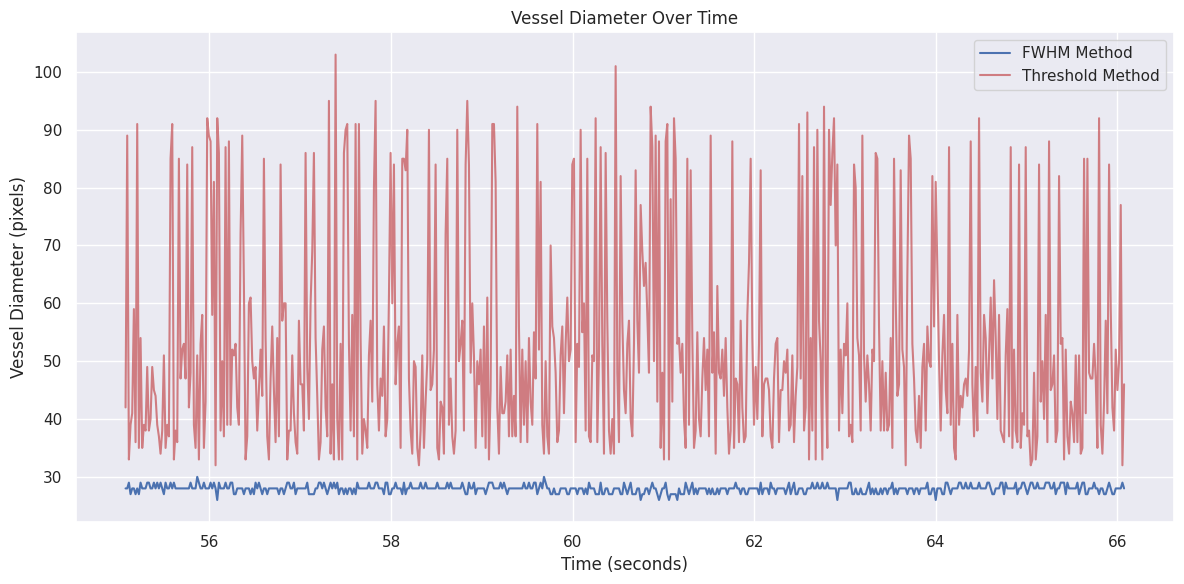

In [14]:
# Plot the vessel diameter time series
plt.figure(figsize=(12, 6))
plt.plot(timestamps, vessel_diameters_fwhm, 'b-', label="FWHM Method")
plt.plot(timestamps, vessel_diameters_threshold, 'r-', alpha=0.7, label="Threshold Method")
plt.title("Vessel Diameter Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Vessel Diameter (pixels)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Step 3: Frequency analysis of vessel pulsatility

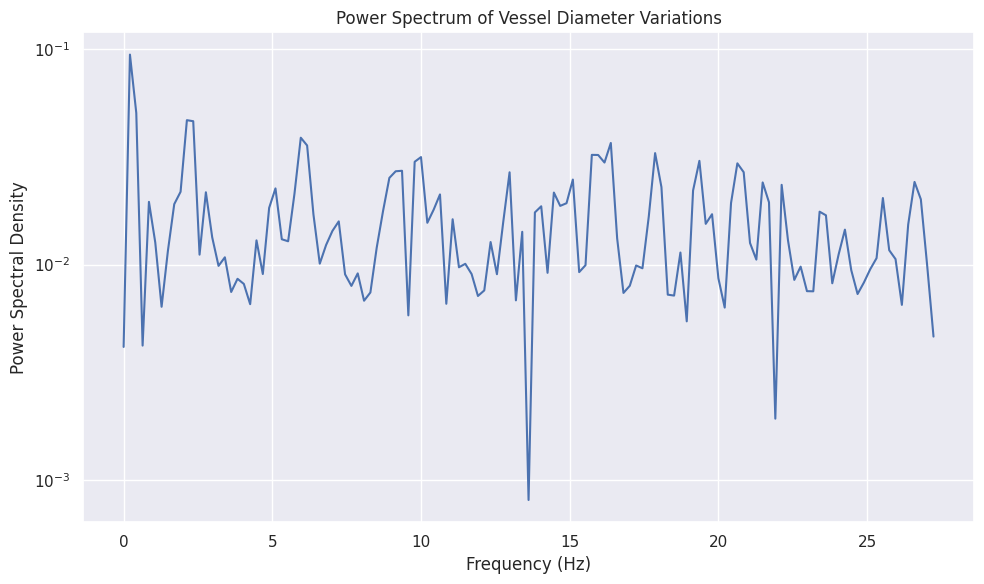

Dominant frequency: 0.21 Hz (approximately 12.8 cycles per minute)

Vessel Diameter Statistics (FWHM method):
Mean: 27.95 pixels
Standard Deviation: 0.68 pixels
Coefficient of Variation: 2.44%
Min: 26.00 pixels
Max: 30.00 pixels
Range: 4.00 pixels


In [15]:
# Calculate and plot the power spectrum for FWHM method
# First remove NaN values if any
valid_diameters_fwhm = vessel_diameters_fwhm[~np.isnan(vessel_diameters_fwhm)]
if len(valid_diameters_fwhm) > 10:
    # Detrend the diameter time series
    detrended_diameters = signal.detrend(valid_diameters_fwhm)
    
    # Calculate the power spectrum
    fps = movies_f15.rate  # frames per second
    freqs, psd = signal.welch(detrended_diameters, fps, nperseg=min(256, len(detrended_diameters)//2))
    
    # Plot the power spectrum
    plt.figure(figsize=(10, 6))
    plt.semilogy(freqs, psd)
    plt.title('Power Spectrum of Vessel Diameter Variations')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Identify dominant frequencies
    peak_indices = signal.find_peaks(psd, height=0)[0]
    if len(peak_indices) > 0:
        dominant_freq_idx = peak_indices[np.argmax(psd[peak_indices])]
        dominant_freq = freqs[dominant_freq_idx]
        print(f"Dominant frequency: {dominant_freq:.2f} Hz (approximately {dominant_freq*60:.1f} cycles per minute)")
    else:
        print("No clear dominant frequency found")
    
    # Calculate basic statistics
    print("\nVessel Diameter Statistics (FWHM method):")
    print(f"Mean: {np.nanmean(vessel_diameters_fwhm):.2f} pixels")
    print(f"Standard Deviation: {np.nanstd(vessel_diameters_fwhm):.2f} pixels")
    print(f"Coefficient of Variation: {np.nanstd(vessel_diameters_fwhm)/np.nanmean(vessel_diameters_fwhm)*100:.2f}%")
    print(f"Min: {np.nanmin(vessel_diameters_fwhm):.2f} pixels")
    print(f"Max: {np.nanmax(vessel_diameters_fwhm):.2f} pixels")
    print(f"Range: {np.nanmax(vessel_diameters_fwhm) - np.nanmin(vessel_diameters_fwhm):.2f} pixels")
else:
    print("Not enough valid diameter measurements for frequency analysis")

## Comparison of M4 and F15 Datasets

Now let's compare a sample from both datasets to understand the differences in vessel structure and imaging quality.

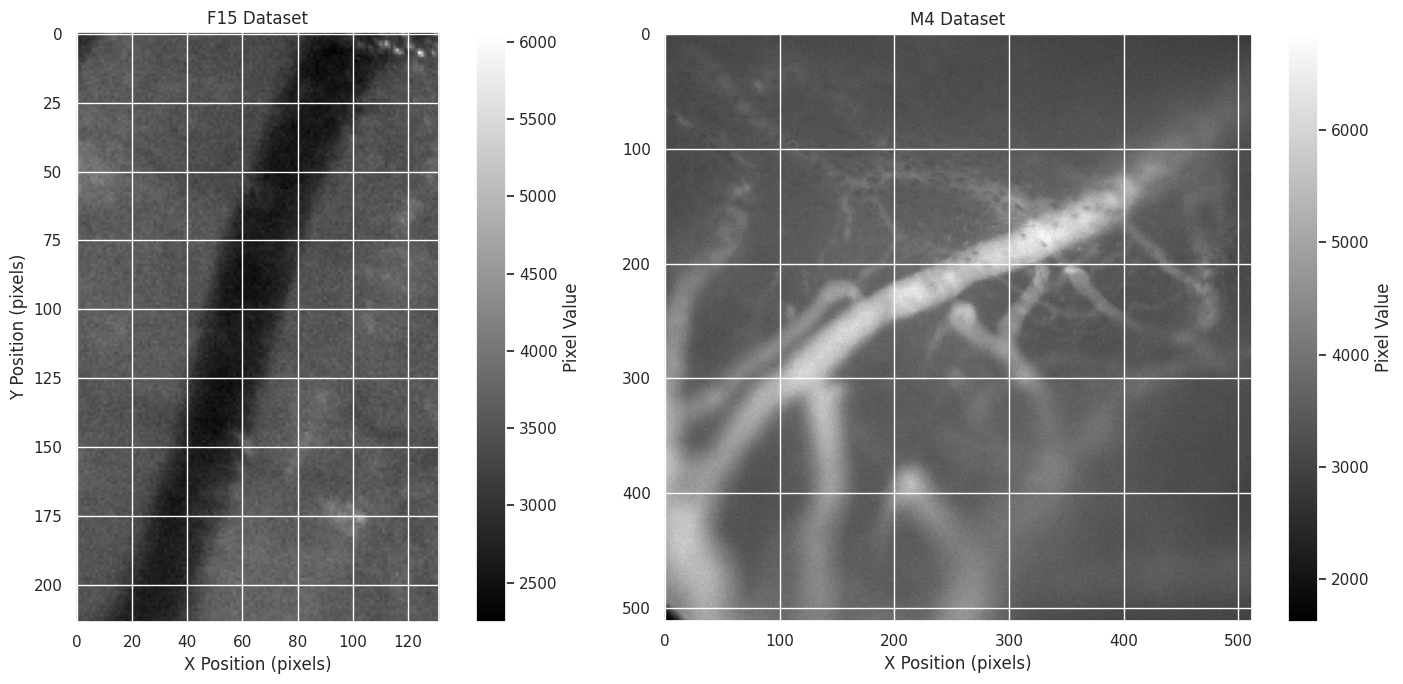

In [16]:
# Load a frame from each dataset
frame_f15 = movies_f15.data[1000, :, :]
frame_m4 = movies_m4.data[1000, :, :]

# Create a figure to display both frames side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Display F15 frame
im0 = axes[0].imshow(frame_f15, cmap='gray')
axes[0].set_title("F15 Dataset")
axes[0].set_xlabel("X Position (pixels)")
axes[0].set_ylabel("Y Position (pixels)")
fig.colorbar(im0, ax=axes[0], label='Pixel Value')

# Display M4 frame
im1 = axes[1].imshow(frame_m4, cmap='gray')
axes[1].set_title("M4 Dataset")
axes[1].set_xlabel("X Position (pixels)")
plt.colorbar(im1, ax=axes[1], label='Pixel Value')

plt.tight_layout()
plt.show()

### Key differences between the datasets:

1. **Resolution**: The M4 dataset has higher resolution (512x512 pixels) compared to F15 dataset (214x132 pixels)
2. **Frame Rate**: F15 dataset has higher frame rate (54.47 fps) compared to M4 dataset (30 fps)
3. **Duration**: M4 dataset is longer (200 seconds) compared to F15 dataset (175 seconds)
4. **Vessel Appearance**: In F15, vessels appear as dark structures, while in M4 they appear as bright structures
5. **Contrast**: M4 dataset generally has better contrast between vessels and background

## Advanced Visualization: Vessel Intensity Over Time

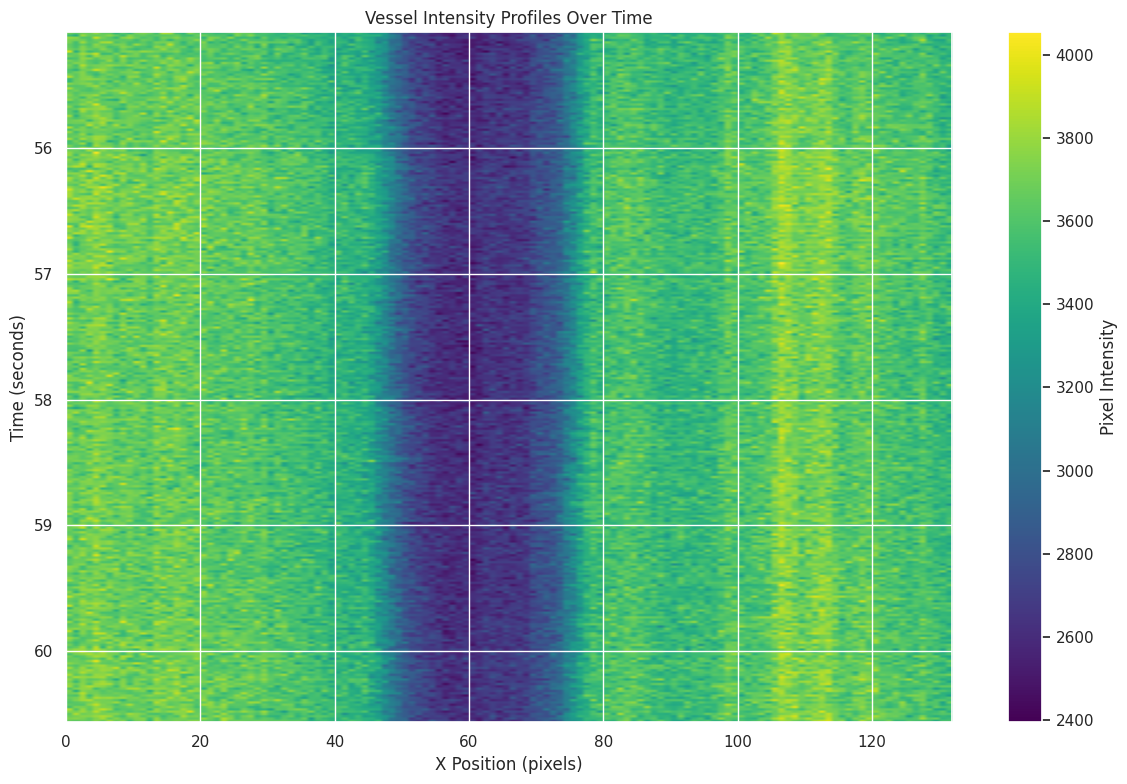

In [17]:
# Create a heatmap visualization of vessel intensity profiles over time
# We'll use the F15 dataset
n_frames_heatmap = 300
start_frame_heatmap = 3000

# Extract intensity profiles along the measurement line for all frames
intensity_profiles = np.array([movies_f15.data[i, y_position, :] for i in range(start_frame_heatmap, start_frame_heatmap + n_frames_heatmap)])

# Create timestamps for the heatmap
timestamps_heatmap = np.array([i / movies_f15.rate for i in range(start_frame_heatmap, start_frame_heatmap + n_frames_heatmap)])

# Plot the intensity profiles as a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(intensity_profiles, aspect='auto', cmap='viridis', 
           extent=[0, intensity_profiles.shape[1], timestamps_heatmap[-1], timestamps_heatmap[0]])
plt.colorbar(label='Pixel Intensity')
plt.title("Vessel Intensity Profiles Over Time")
plt.xlabel("X Position (pixels)")
plt.ylabel("Time (seconds)")
plt.tight_layout()
plt.show()

This heatmap visualization shows how the vessel intensity changes over time. Each horizontal line represents the intensity profile along our measurement line at a specific time point. This allows us to visualize vessel pulsations and other dynamics.

## Using Edge Detection to Highlight Vessel Boundaries

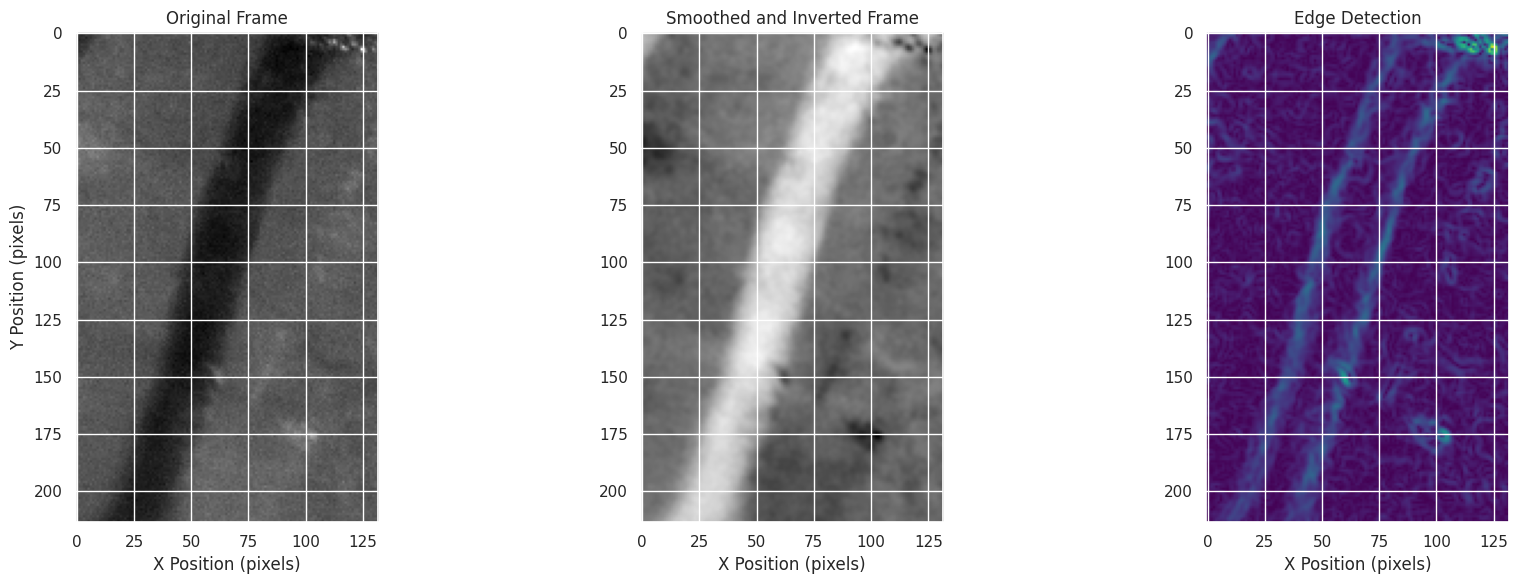

In [18]:
# Apply Sobel edge detection to highlight vessel boundaries
from scipy.ndimage import sobel

# Load a sample frame
frame = movies_f15.data[1000, :, :]

# Normalize and smooth the frame
normalized_frame = frame.astype(float) / np.max(frame)
smoothed_frame = gaussian_filter1d(normalized_frame, sigma=1.0, axis=0)
smoothed_frame = gaussian_filter1d(smoothed_frame, sigma=1.0, axis=1)

# Apply edge detection
# The vessel in F15 dataset is dark, so we'll invert it first
inverted_frame = 1.0 - smoothed_frame
edges_x = sobel(inverted_frame, axis=1)
edges_y = sobel(inverted_frame, axis=0)
edges = np.sqrt(edges_x**2 + edges_y**2)

# Create a figure with multiple panels
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original frame
axes[0].imshow(frame, cmap='gray')
axes[0].set_title("Original Frame")
axes[0].set_xlabel("X Position (pixels)")
axes[0].set_ylabel("Y Position (pixels)")

# Smoothed and inverted frame
axes[1].imshow(inverted_frame, cmap='gray')
axes[1].set_title("Smoothed and Inverted Frame")
axes[1].set_xlabel("X Position (pixels)")

# Edge detection result
axes[2].imshow(edges, cmap='viridis')
axes[2].set_title("Edge Detection")
axes[2].set_xlabel("X Position (pixels)")

plt.tight_layout()
plt.show()

Edge detection is another useful technique for visualizing vessel boundaries. This can be particularly helpful when trying to identify vessel edges for diameter measurement.

## Summary and Conclusions

In this notebook, we explored the Dandiset 001366, which contains imaging data of pial blood vessels from mice. The dataset's focus is on comparing different approaches for quantifying vessel diameter and pulsatility.

Key findings from our analysis:

1. **Dataset Structure**: The Dandiset contains two NWB files with different resolutions, frame rates, and vessel imaging characteristics.

2. **Vessel Diameter Measurement**: We implemented and compared two methods for vessel diameter measurement:
   - Full Width at Half Maximum (FWHM): More robust to noise, but may underestimate vessel diameter
   - Threshold-based method: Simple to implement, but highly dependent on threshold selection

3. **Vessel Pulsatility**: We observed clear pulsations in vessel diameter over time, with a dominant frequency that likely corresponds to the cardiac cycle.

4. **Visualization Techniques**: We demonstrated various visualization techniques for vessel analysis, including:
   - Direct imaging of vessel frames
   - Intensity profiles across vessels
   - Time series of vessel diameter
   - Frequency analysis of pulsatility
   - Heatmap visualization of intensity profiles over time
   - Edge detection for highlighting vessel boundaries

### Potential Future Directions

The Dandiset provides opportunities for further research, such as:

1. Implementing and comparing more advanced methods for vessel diameter measurement, such as Radon transform-based approaches

2. Analyzing the effects of physiological conditions on vessel pulsatility

3. Developing automated methods for tracking vessels across frames and measuring their dynamics

4. Performing comparative studies between different subjects or experimental conditions

5. Developing machine learning approaches for automated vessel segmentation and diameter measurement

## References

- Dandiset 001366: [https://dandiarchive.org/dandiset/001366/0.250324.1603](https://dandiarchive.org/dandiset/001366/0.250324.1603)
- PyNWB documentation: [https://pynwb.readthedocs.io/](https://pynwb.readthedocs.io/)
- Neurosift: [https://neurosift.app/](https://neurosift.app/)